In [1]:
from typing import Union

from vivarium.core.types import State, Update

from pbg.translate import get_port_mapping
from pbg.parse import get_process, find_defaults
from process_bigraph import ProcessTypes, pp
from bigraph_schema.type_system import required_schema_keys, optional_schema_keys
from ecoli.processes.antibiotics.cell_wall import CellWall
from vivarium.core.registry import process_registry
from vivarium.core.process import Process as VivariumProcess
from ecoli.processes.registries import topology_registry
from vivarium_interface.vivarium import Vivarium
from pbg.data_model.base_process import BaseProcess, CORE
from pbg.parse import find_defaults

<unknown>:1: SyntaxWarning: invalid escape sequence '\s'


In [2]:
core = ProcessTypes()

In [3]:
class Add(BaseProcess):
    defaults = {
        'k': 0.11 / 2.22
    }
    name = 'add'

    def __init__(self, parameters=None, core=None):
        super().__init__(parameters, core=core)

    def ports_schema(self):
        return {
            'A': {
                'x': {
                    '_default': -0.11,
                    '_emit': True,
                },
            },
            'B': {
                'y': {
                    '_default': 0.22,
                    '_emit': True,
                }
            }
        }

    def next_update(
            self, timestep, states):
        x0 = states['A']['x']
        x = x0 * self.parameters['k'] * timestep
        return {
            'A': {
                'x': x,
            },
            'B': {
                'y': x0 + (x * timestep)
            }
        }


core.register_process('Add', Add)

In [4]:
types: dict = core.types()
processes = core.process_registry.registry
processes.update(process_registry.registry)
type_keys: set = required_schema_keys.union(optional_schema_keys)

In [5]:
viv: Vivarium = Vivarium(types=types, processes=processes)

In [6]:
viv.add_process(process_id='Add', name='add', config={'k': -11.11})

viv

Vivarium( 
{ 'add': { 'address': 'local:Add',
           'config': {'k': -11.11, 'timestep': 1.0},
           'inputs': {},
           'instance': <__main__.Add object at 0x16af21ee0>,
           'interval': 1.0,
           'outputs': {}},
  'global_time': 0.0})

In [7]:
proc: BaseProcess = viv.get_state()['add']['instance']

proc.inputs()

{'A': {'x': 'float'}, 'B': {'y': 'float'}}

In [10]:
state = find_defaults(proc.ports_schema())

viv.connect_process(
    process_name='add',
    inputs={
        'A': ['A']
    },
    outputs={
        'B': ['B']
    }
)

viv

Vivarium( 
{ 'A': {'x': -11.11},
  'B': {'y': 22.22},
  'add': { 'address': 'local:Add',
           'config': {'k': -11.11, 'timestep': 1.0},
           'inputs': {'A': ['A']},
           'instance': <__main__.Add object at 0x16af21ee0>,
           'interval': 1.0,
           'outputs': {'B': ['B']}},
  'global_time': 0.0})

In [11]:
viv.set_value(path=['A', 'x'], value=-11.11)
viv.set_value(path=['B', 'y'], value=22.22)

viv

Vivarium( 
{ 'A': {'x': -11.11},
  'B': {'y': 22.22},
  'add': { 'address': 'local:Add',
           'config': {'k': -11.11, 'timestep': 1.0},
           'inputs': {'A': ['A']},
           'instance': <__main__.Add object at 0x16af21ee0>,
           'interval': 1.0,
           'outputs': {'B': ['B']}},
  'global_time': 0.0})

In [12]:
viv.add_emitter()

viv

Vivarium( 
{ 'A': {'x': -11.11},
  'B': {'y': 22.22},
  'add': { 'address': 'local:Add',
           'config': {'k': -11.11, 'timestep': 1.0},
           'inputs': {'A': ['A']},
           'instance': <__main__.Add object at 0x16af21ee0>,
           'interval': 1.0,
           'outputs': {'B': ['B']}},
  'emitter': { 'address': 'local:ram-emitter',
               'config': { 'emit': { 'A': 'any',
                                     'B': 'any',
                                     'global_time': 'any'}},
               'inputs': { 'A': ['A'],
                           'B': ['B'],
                           'global_time': ['global_time']},
               'instance': <process_bigraph.composite.RAMEmitter object at 0x16b4129c0>,
               'outputs': None},
  'global_time': 0.0})

In [13]:
viv.run(3)
viv.get_timeseries()

,global_time,A.x,B.y
0,0.0,-11.11,22.2200
1,1.0,-11.11,134.5421
2,2.0,-11.11,246.8642
3,3.0,-11.11,359.1863


In [24]:
doc = viv.make_document()

from process_bigraph import Composite

c = Composite(
    config={'state': doc['state']['add']}, core=core)

In [26]:
c.state

{'global_time': 0.0,
 'inputs': {'A': ['A']},
 'outputs': {'B': ['B']},
 'interval': 1.0,
 'address': 'local:Add',
 'config': {'k': '-11.11', 'timestep': '1.0'}}

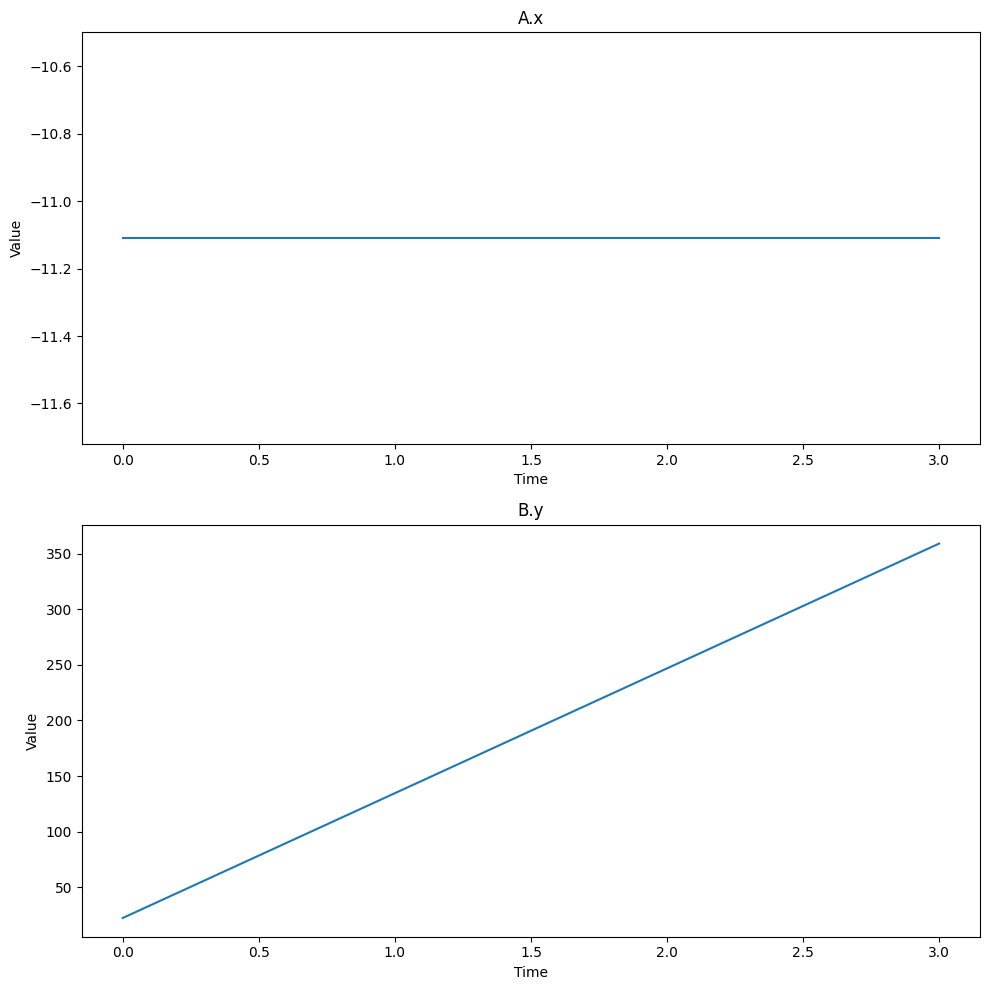

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
viv.plot_timeseries()

In [11]:
wall_id = 'ecoli-cell-wall'
viv.add_process(
    process_id=wall_id,
    name='wall-0'
)

In [18]:
proc2: BaseProcess = viv.get_state()['wall-0']['instance']
proc2.inputs()

{'murein_state': {'incorporated_murein': 'integer',
  'unincorporated_murein': 'integer',
  'shadow_murein': 'integer'},
 'bulk': 'list',
 'shape': {'volume': 'integer'},
 'wall_state': {'lattice': 'any',
  'lattice_rows': 'integer',
  'lattice_cols': 'integer',
  'extension_factor': 'integer',
  'cracked': 'boolean',
  'attempted_shrinkage': 'boolean'},
 'pbp_state': {'active_fraction_PBP1A': 'float',
  'active_fraction_PBP1B': 'float'},
 'listeners': {'porosity': 'integer',
  'hole_size_distribution': 'array',
  'strand_length_distribution': 'list'}}

In [17]:
viv.connect_process(process_name='wall-0')

TypeError: string indices must be integers, not 'str'